In [ ]:
# Install needed libraries (if not preinstalled)
!pip install nilearn nibabel scikit-learn mne matplotlib pandas seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 70.2 MB/s eta 0:00:00


In [ ]:
from nilearn import datasets

# Fetch the Haxby dataset
haxby_dataset = datasets.fetch_haxby(data_dir='.')
print(haxby_dataset.keys())


[_add_readme_to_default_data_locations] Added README.md to .

[get_dataset_dir] Dataset created in haxby2001

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7868/mask.nii.gz ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

[fetch_single_file] Downloading data from http://data.pymvpa.org/datasets/haxby2001/MD5SUMS ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

[fetch_single_file] Downloading data from http://data.pymvpa.org/datasets/haxby2001/subj2-2010.01.14.tar.gz ...

[_chunk_report_] Downloaded 86687744 of 291168628 bytes (29.8%%,    2.4s remaining)

[_chunk_report_] Downloaded 201228288 of 291168628 bytes (69.1%%,    0.9s remaining)

[fetch_single_file]  ...done. (3 seconds, 0 min)

[uncompress_file] Extracting data from haxby2001/9cabe068089e791ef0c5fe930fc20e30/subj2-2010.01.14.tar.gz...

[uncompress_file] .. done.

dict_keys(['anat', 'func', 'session_target', 'mask_vt', 'mask_face', 'mask_house', 'mask_face_little', 'mask_house_little', 'mask', 'description'])


In [ ]:
from nilearn.image import index_img
from nilearn.input_data import NiftiMasker
import pandas as pd

# Load behavioral labels
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

# Create mask for non-'rest' conditions
condition_mask = labels['labels'] != 'rest'
labels_filtered = labels[condition_mask]

# Select corresponding fMRI volumes
fmri_img = index_img(haxby_dataset.func[0], condition_mask)

# Apply mask and standardize
masker = NiftiMasker(mask_img=haxby_dataset.mask_vt[0], standardize=True)
fmri_masked = masker.fit_transform(fmri_img)

# Get labels
targets = labels_filtered['labels'].values

print(f"Shape of masked data: {fmri_masked.shape}")
print(f"Number of labels: {len(targets)}")


/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:489: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


Shape of masked data: (864, 464)
Number of labels: 864


In [ ]:
from sklearn.decomposition import PCA

# Reduce to 100 components
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(fmri_masked)


In [ ]:
from sklearn.decomposition import PCA

# X_filtered is already fmri_masked (864 x voxels)
X_filtered = fmri_masked

# Reduce to 100 components
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X_filtered)


In [ ]:
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.image import index_img
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pandas as pd

# Load Haxby dataset
haxby_dataset = datasets.fetch_haxby(data_dir='.')
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

# Filter out 'rest' condition
condition_mask = labels['labels'] != 'rest'
labels_filtered = labels[condition_mask]
targets = labels_filtered['labels'].values

# Filter fMRI image to match labels
fmri_img = index_img(haxby_dataset.func[0], condition_mask)

# Apply mask
masker = NiftiMasker(mask_img=haxby_dataset.mask_vt[0], standardize=True)
fmri_masked = masker.fit_transform(fmri_img)  # Now shape (864, n_voxels)

# Confirm shapes match
print("fmri_masked shape:", fmri_masked.shape)
print("targets shape:", targets.shape)

# PCA on filtered data only
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(fmri_masked)  # Shape: (864, 100)

# Split for classification
X_train, X_test, y_train, y_test = train_test_split(X_reduced, targets, test_size=0.2, random_state=42)

# Confirm shape
print("X_train:", X_train.shape, "| y_train:", y_train.shape)


[get_dataset_dir] Dataset found in haxby2001

/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:489: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


fmri_masked shape: (864, 464)
targets shape: (864,)
X_train: (691, 100) | y_train: (691,)


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the classifier
clf = SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

      bottle       0.65      0.81      0.72        21
         cat       0.83      0.79      0.81        19
       chair       0.78      0.90      0.84        20
        face       0.83      0.75      0.79        20
       house       1.00      0.93      0.97        15
    scissors       0.91      0.70      0.79        30
scrambledpix       0.92      1.00      0.96        22
        shoe       0.89      0.92      0.91        26

    accuracy                           0.84       173
   macro avg       0.85      0.85      0.85       173
weighted avg       0.85      0.84      0.84       173



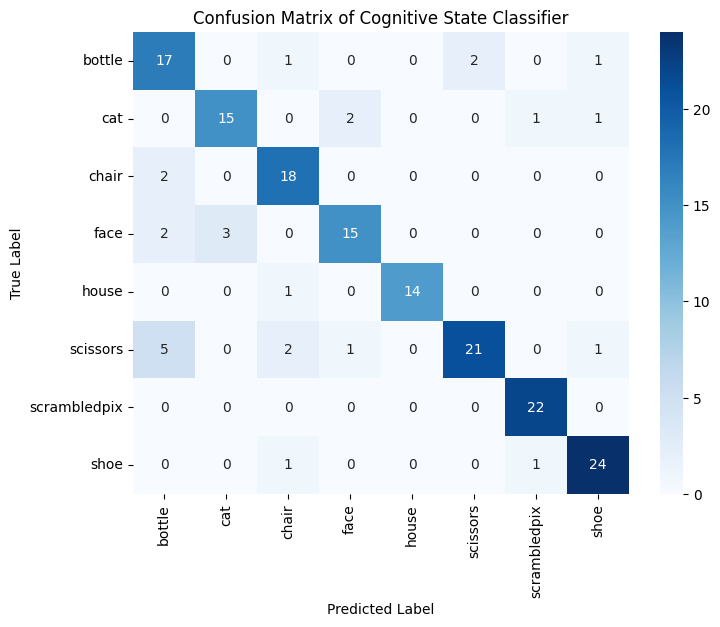

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of Cognitive State Classifier")
plt.show()


/usr/local/lib/python3.11/dist-packages/nilearn/plotting/displays/_slicers.py:313: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


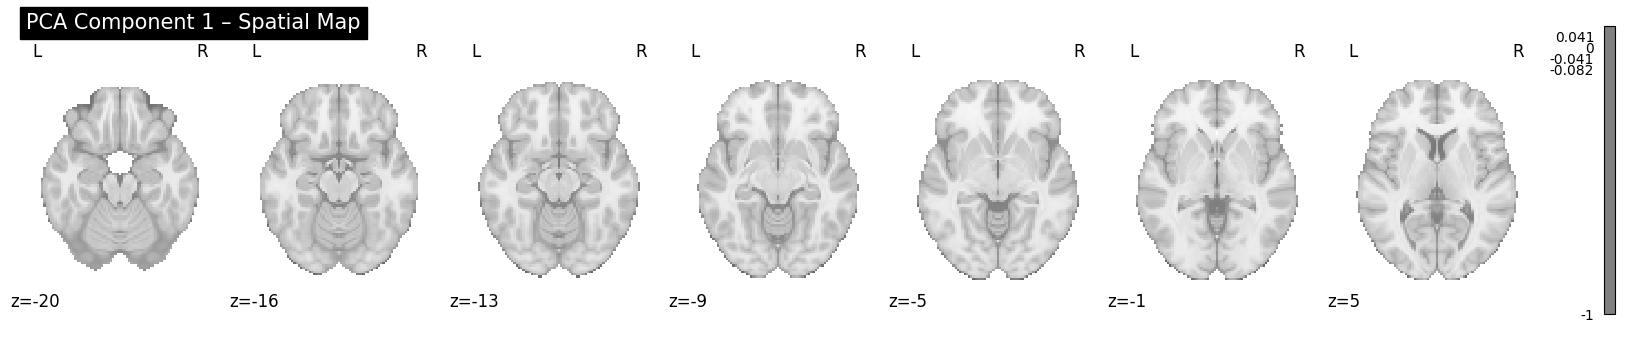

In [ ]:
from nilearn.plotting import plot_stat_map

# Inverse transform the first PCA component to brain image space
component_0_img = masker.inverse_transform(pca.components_[0])

# Plot brain map
plot_stat_map(component_0_img, title='PCA Component 1 – Spatial Map',
              display_mode='z', cut_coords=7, threshold=1.0)


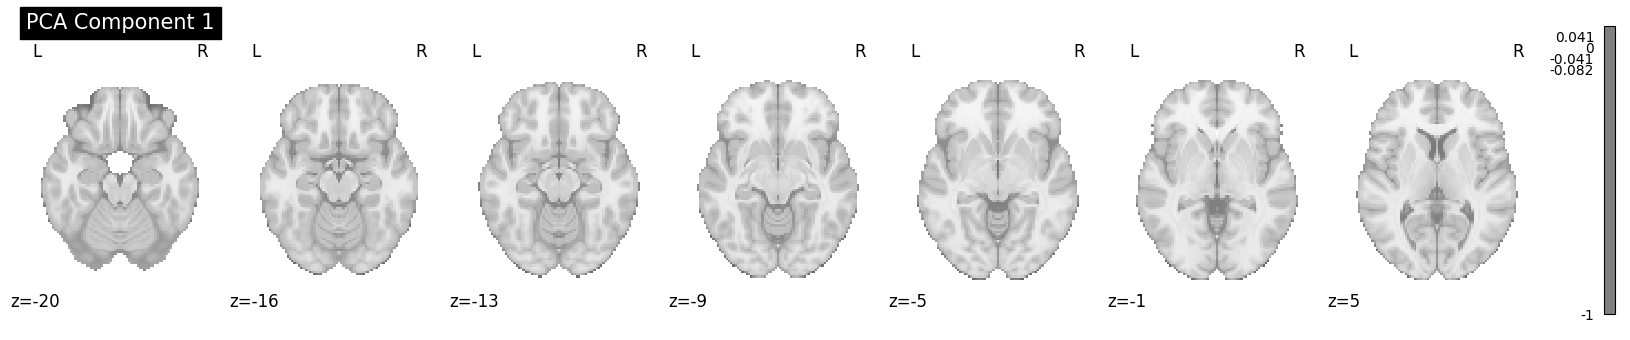

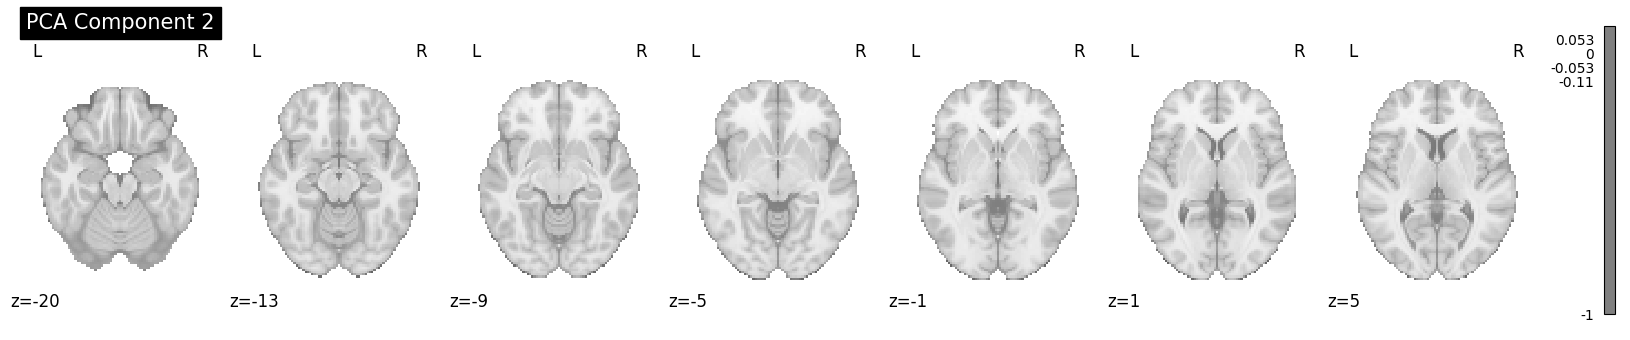

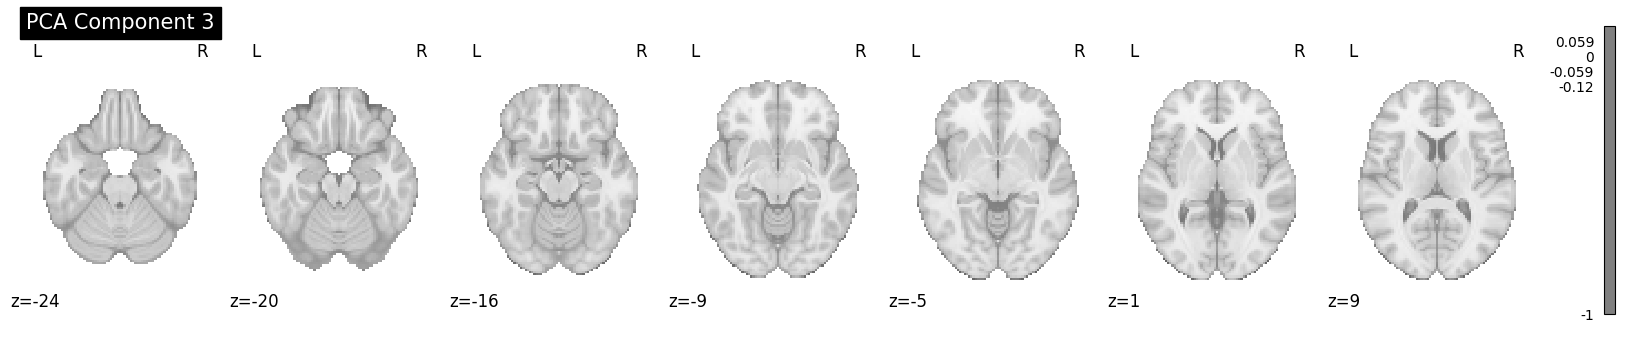

In [ ]:
for i in range(3):
    component_img = masker.inverse_transform(pca.components_[i])
    plot_stat_map(component_img, title=f'PCA Component {i+1}',
                  display_mode='z', cut_coords=7, threshold=1.0)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader


In [ ]:
# Encode labels to integers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
class BrainNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(BrainNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = BrainNet(input_dim=100, num_classes=len(le.classes_))


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {running_loss/len(train_loader):.4f}")


In [20]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00


2025-04-19 15:06:51.400 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 15:06:51.403 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 15:06:51.696 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-19 15:06:51.701 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


[_add_readme_to_default_data_locations] Added README.md to /root/nilearn_data

[get_dataset_dir] Dataset created in /root/nilearn_data/haxby2001

[fetch_single_file] Downloading data from https://www.nitrc.org/frs/download.php/7868/mask.nii.gz ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

[fetch_single_file] Downloading data from http://data.pymvpa.org/datasets/haxby2001/MD5SUMS ...

[fetch_single_file]  ...done. (0 seconds, 0 min)

[fetch_single_file] Downloading data from http://data.pymvpa.org/datasets/haxby2001/subj2-2010.01.14.tar.gz ...

[_chunk_report_] Downloaded 55918592 of 291168628 bytes (19.2%%,    4.2s remaining)

[_chunk_report_] Downloaded 97869824 of 291168628 bytes (33.6%%,    4.0s remaining)

[_chunk_report_] Downloaded 139845632 of 291168628 bytes (48.0%%,    3.3s remaining)

[_chunk_report_] Downloaded 183214080 of 291168628 bytes (62.9%%,    2.4s remaining)

[_chunk_report_] Downloaded 202285056 of 291168628 bytes (69.5%%,    2.2s remaining)

[_chunk_report_] Downloaded 248053760 of 291168628 bytes (85.2%%,    1.0s remaining)

[_chunk_report_] Downloaded 289710080 of 291168628 bytes (99.5%%,    0.0s remaining)

[fetch_single_file]  ...done. (7 seconds, 0 min)

[uncompress_file] Extracting data from 
/root/nilearn_data/haxby2001/9cabe068089e791ef0c5fe930fc20e30/subj2-2010.01.14.tar.gz...

[uncompress_file] .. done.

/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:489: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
2025-04-19 15:07:16.662 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 15:07:16.663 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 15:07:16.665 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 15:07:16.666 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 15:07:16.669 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 15:07:16.670 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-19 15:07:16.671 Thread

DeltaGenerator()

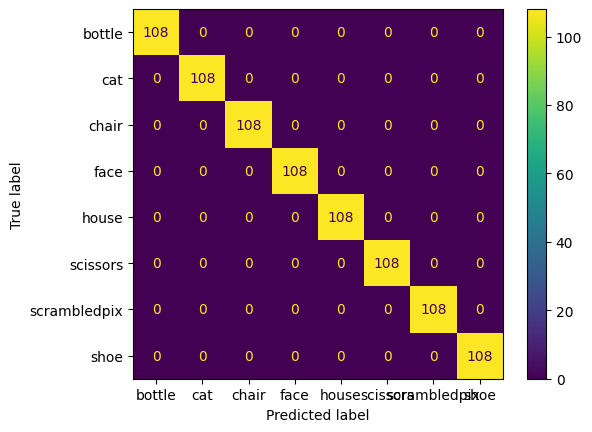

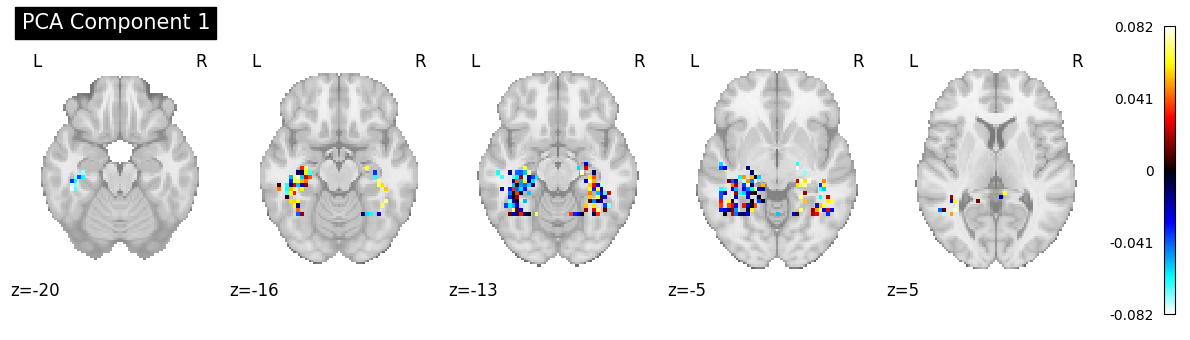

In [21]:
import streamlit as st
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import joblib
from nilearn import plotting, image
from nilearn.datasets import fetch_haxby
from nilearn.input_data import NiftiMasker
import matplotlib.pyplot as plt

st.set_page_config(page_title="fMRI Classifier", layout="wide")

st.title("🧠 fMRI Cognitive State Classifier")

# Load data (optional: let users upload their own)
haxby = fetch_haxby()
labels = pd.read_csv(haxby.session_target[0], sep=" ")
masker = NiftiMasker(mask_img=haxby.mask_vt[0], standardize=True)

# Process uploaded or default fMRI
condition_mask = labels['labels'] != 'rest'
labels_filtered = labels[condition_mask]
fmri_img = image.index_img(haxby.func[0], condition_mask)
fmri_masked = masker.fit_transform(fmri_img)
targets = labels_filtered['labels'].values

# Sidebar
st.sidebar.header("Parameters")
component = st.sidebar.slider("PCA Components", 10, 150, 100)
classifier_type = st.sidebar.selectbox("Classifier", ["SVM"])

# Encode labels
le = LabelEncoder()
targets_enc = le.fit_transform(targets)

# PCA
pca = PCA(n_components=component)
X_reduced = pca.fit_transform(fmri_masked)

# Classifier
if classifier_type == "SVM":
    clf = SVC(kernel="linear", probability=True)
    clf.fit(X_reduced, targets_enc)

# Predict
y_pred = clf.predict(X_reduced)
acc = np.mean(y_pred == targets_enc)

st.subheader("📈 Classification Accuracy")
st.success(f"{acc:.2%}")

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targets_enc, y_pred)
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax)
st.pyplot(fig)

# Brain Map
st.subheader("🧠 PCA Component Brain Map")

pca_component = st.slider("Select PCA Component to View", 0, component - 1, 0)
component_img = masker.inverse_transform(pca.components_[pca_component])

plot_path = "brain_component.png"
display = plotting.plot_stat_map(component_img, display_mode="z", cut_coords=5, title=f"PCA Component {pca_component+1}")
display.savefig(plot_path)
st.image(plot_path, caption="Topographic Brain Map", use_column_width=True)
